## Imports

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from IPython.display import display

# use the notebook's working directory
ROOT_DIR = Path().resolve().parent
sys.path.append(str(ROOT_DIR))

import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from utility.file_utils import get_csv_dataframe  # noqa: E402

## Load data and run initial computations

In [2]:
# Load in data for before and after processing
df_before_processing = get_csv_dataframe("../data/Merged_dataset.csv")
df_after_processing = pl.read_parquet("../data/data.parquet").to_pandas()

In [3]:
# Compute text lengths
text_lengths = [len(text.split()) for text in df_before_processing["text"]]

## Pre-processed data statistics

### Run Text Length Histogram

#### Plot settings

In [4]:
title_text = "Histogram of Text Lengths"
x_axis_label = "Text Length"
y_axis_label = "Frequency"
number_of_bins = 50
histogram_color = "skyblue"
linestyle = "--"
line_color = "black"

graph_name = "text_length_histogram"

#### Create plot and save to graph folder

Saved histogram in graphs/text_length_histogram.png


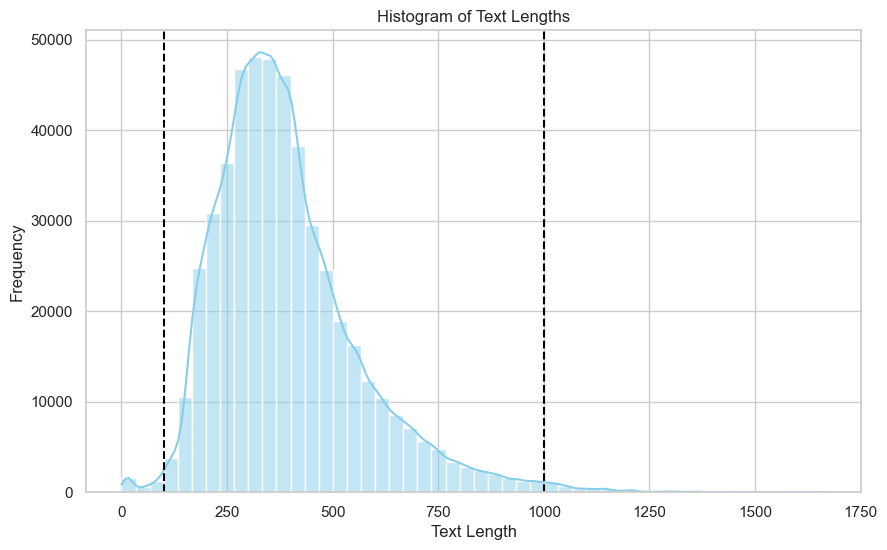

In [5]:
# Minumum and Maximum text lengths we cut off
min_len = 100
max_len = 1000

# Initialize plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(text_lengths, bins=number_of_bins, kde=True, color=histogram_color)

# Add vertical lines for min and max lengths
plt.axvline(min_len, color=line_color, linestyle=linestyle)
plt.axvline(max_len, color=line_color, linestyle=linestyle)

plt.title(title_text)
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)

plt.savefig(f"../graphs/{graph_name}.png")
print(f"Saved histogram in graphs/{graph_name}.png")
plt.show()

### Calculate basic statistics

In [6]:
numeric_cols = [
    "word_count",
    "character_count",
    "lexical_diversity",
    "avg_sentence_length",
    "avg_word_length",
    "flesch_reading_ease",
    "gunning_fog_index",
    "punctuation_ratio",
]
print("Basic statistics before processing:")
display(df_before_processing[numeric_cols].describe())

gen_pct = df_before_processing["generated"].value_counts(normalize=True).to_pandas()

# keep only columns you want + rename
result = gen_pct.loc[:, ["generated", "proportion"]].rename(
    columns={"generated": "label", "proportion": "percentage"}
)

# convert to %
result["percentage"] = (result["percentage"] * 100).round(2)

# print without index
print("Label distribution before processing:")
print(result.to_string(index=False))

Basic statistics before processing:


statistic,word_count,character_count,lexical_diversity,avg_sentence_length,avg_word_length,flesch_reading_ease,gunning_fog_index,punctuation_ratio
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",492812.0,492812.0,492812.0,492812.0,492812.0,492733.0,492777.0,492812.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,79.0,35.0,0.0
"""mean""",397.514423,2264.911108,0.453411,20.670846,4.579122,56.853163,12.877321,0.02132
"""std""",172.445259,997.445466,0.09682,12.189901,0.499088,18.459178,5.23411,0.007537
"""min""",0.0,1.0,0.0,0.0,0.0,-644.180316,0.0,0.0
"""25%""",281.0,1577.0,0.389722,16.444444,4.225403,47.472014,10.280995,0.016758
"""50%""",368.0,2101.0,0.445,19.25,4.508333,59.0875,12.32093,0.020062
"""75%""",478.0,2726.0,0.507042,22.454545,4.856397,68.739064,14.789622,0.024344
"""max""",1680.0,18322.0,1.0,754.0,50.6,118.175,293.220908,1.0


Label distribution before processing:
 label  percentage
     0       62.75
     1       37.25


## Post-processed data statistics

### Run PCA on embeddings

In [7]:
# Columns to append to embedding
numeric_cols = [
    "word_count",
    "character_count",
    "lexical_diversity",
    "avg_sentence_length",
    "avg_word_length",
    "flesch_reading_ease",
    "gunning_fog_index",
    "punctuation_ratio",
]

# ---------------------------
# 1. Combine embedding + numeric features (vectorized)
# ---------------------------

# Stack embeddings into a single 2D array
print("Stacking embeddings...")
emb_list = df_after_processing["embedding"].values
# Using tqdm for a progress bar during conversion to array if needed
emb_list = df_after_processing["embedding"].values
emb_array = np.vstack(list(tqdm(emb_list, desc="Embedding stacking")))
# Convert numeric features to array
numeric_array = df_after_processing[numeric_cols].to_numpy()

# Horizontally stack embeddings + numeric features
combined_features = np.hstack([emb_array, numeric_array])
print(f"Combined feature shape: {combined_features.shape}")

# ---------------------------
# 2. Normalize features
# ---------------------------
scaler = StandardScaler()
combined_features_scaled = scaler.fit_transform(combined_features)

# ---------------------------
# 3. Run PCA
# ---------------------------
print("Running PCA...")
pca = PCA(n_components=5, svd_solver="randomized")
pca_result = pca.fit_transform(combined_features_scaled)
print("PCA complete.")

# ---------------------------
# 4. print explained variance
# ---------------------------
# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Build DataFrame
pca_table = pd.DataFrame(
    {
        "PC": [f"PC{i}" for i in range(1, len(explained_var) + 1)],
        "Explained Variance (%)": (explained_var * 100).round(2),
        "Cumulative Variance (%)": (cumulative_var * 100).round(2),
    }
)

# Display nicely
display(pca_table)

Stacking embeddings...


Embedding stacking: 100%|██████████| 992344/992344 [00:00<00:00, 5764753.54it/s]


Combined feature shape: (992344, 392)
Running PCA...
PCA complete.


,PC,Explained Variance (%),Cumulative Variance (%)
0,PC1,7.99,7.99
1,PC2,7.20,15.19
2,PC3,5.98,21.17
3,PC4,4.17,25.34
4,PC5,3.47,28.82


#### Plot Settings

In [8]:
x_label_text = "PCA Component 1"
y_label_text = "PCA Component 2"
title_text = "PCA of Text Embeddings and metadata"
pca_graph_name = "embedding_pca_scatterplot"
legend_label_0_text = "label = 0"
legend_label_1_text = "label = 1"

label_0_color = "blue"
label_1_color = "red"

#### Visualize PCA results

Saved histogram in graphs/text_length_histogram.png


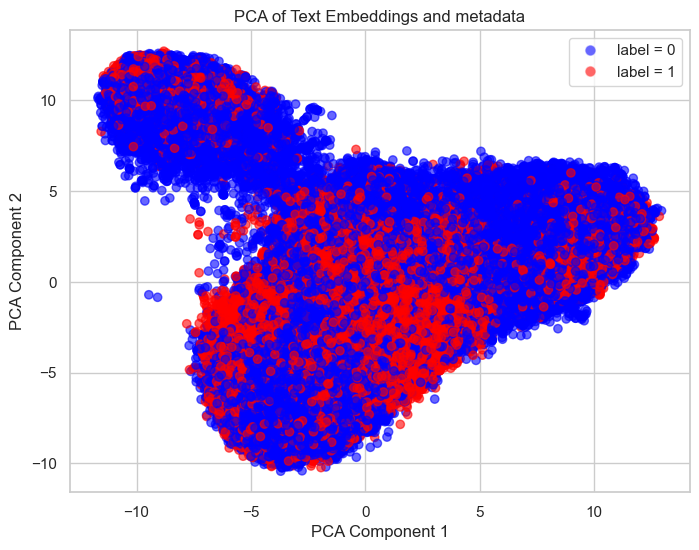

In [9]:
# ---------------------------
# 4. Scatter plot colored by 'generated'
# ---------------------------
# Separate the two classes
# Define discrete colors for 0 and 1
cmap = ListedColormap([label_0_color, label_1_color])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1], c=df_after_processing["generated"], cmap=cmap, alpha=0.6
)

# Create a custom legend
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=legend_label_0_text,
        markerfacecolor="blue",
        markersize=8,
        alpha=0.6,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=legend_label_1_text,
        markerfacecolor="red",
        markersize=8,
        alpha=0.6,
    ),
]
plt.legend(handles=handles)

plt.xlabel(x_label_text)
plt.ylabel(y_label_text)
plt.title(title_text)

plt.savefig(f"../graphs/{graph_name}.png")
print(f"Saved histogram in graphs/{graph_name}.png")
plt.show()

### Calculate basic statistics

In [10]:
numeric_cols = [
    "word_count",
    "character_count",
    "lexical_diversity",
    "avg_sentence_length",
    "avg_word_length",
    "flesch_reading_ease",
    "gunning_fog_index",
    "punctuation_ratio",
]

print("Basic statistics after processing:")
display(df_after_processing[numeric_cols].describe())

# compute percentage of generated labels
gen_pct = (
    df_after_processing["generated"]
    .value_counts(normalize=True)
    .rename_axis("label")
    .reset_index(name="percentage")
)

gen_pct["percentage"] = (gen_pct["percentage"] * 100).round(2)

print("Label distribution after processing:")
print(gen_pct[["label", "percentage"]].to_string(index=False))

Basic statistics after processing:


,word_count,character_count,lexical_diversity,avg_sentence_length,avg_word_length,flesch_reading_ease,gunning_fog_index,punctuation_ratio
count,992344.000000,992344.000000,992344.000000,992344.000000,992344.000000,992344.000000,992344.000000,992344.000000
mean,191.957529,1090.795002,0.562281,19.929361,4.582898,57.431313,12.634074,0.021390
std,32.392067,205.374747,0.076969,8.991412,0.501038,16.981567,4.213850,0.007865
min,100.000000,491.000000,0.009756,2.531250,2.985816,-170.027313,1.729412,0.000000
25%,169.000000,945.000000,0.512563,15.846154,4.226519,47.791710,10.061679,0.016447
50%,192.000000,1085.000000,0.560386,18.636364,4.519737,59.578785,12.115000,0.020050
75%,216.000000,1235.000000,0.608696,21.888889,4.869863,69.248154,14.611981,0.024681
max,307.000000,2351.000000,0.985816,255.000000,10.797752,106.759827,102.848579,0.193437


Label distribution after processing:
 label  percentage
 False       65.33
  True       34.67
